In [3]:
import pandas as pd
import lightgbm as lgb

In [4]:
train_monthly = pd.read_pickle("train_monthly.pkl")

In [5]:
# Dropping some features due to data leakage leding to significant -
# - overfitting or which are not helping in improving model accuracy

train_monthly.drop(
    [
        "mean_item_cnt",
        "transactions",
        "qmean_rev",
        "mean_item_cnt_lag_2",
        "mean_item_cnt_lag_3",
        "revenue_lag_1",
        "revenue_lag_2",
        "revenue_lag_3",
        "item_cnt_min",
        "transactions_lag_2",
        "transactions_lag_3",
        "transactions_lag_6",
        "item_cnt_max",
        "item_cnt_mean",
        "date_shop_type_avg_item_cnt_lag_1",
        "date_shop_type_avg_item_cnt_lag_2",
        "date_shop_type_avg_item_cnt_lag_3",
        "date_item_city_avg_item_cnt_lag_3",
        "date_type_avg_item_cnt_lag_3",
        "date_shop_subcat_avg_item_cnt_lag_3",
        "date_subtype_avg_item_cnt_lag_3",
        "date_shop_cat_avg_item_cnt_lag_3",
        "year",
        
    ],
    axis=1,
    inplace=True,
)

In [6]:
# Hence doesnt provide historic information for model to learn
train_monthly = train_monthly.loc[train_monthly["date_block_num"] > 5]
cat_cols = [
    "shop_id",
    "item_id",
    "item_category_id",
    "city_code",
    "type_code",
    "subcat_code",
    "month",
]

# Lightgbm has in built categorical feature encoding however require such feature as category type
train_monthly[cat_cols] = train_monthly[cat_cols].astype("category")

In [7]:
# Train-Validation-Test Split - Take 1 month of data as validation and month = 33 as our test since we dont have data for month = 34
X_train = train_monthly.loc[train_monthly["date_block_num"] < 33].drop(
    ["item_cnt"], axis=1
)
y_train = train_monthly.loc[train_monthly["date_block_num"] < 33]["item_cnt"]

X_val = train_monthly.loc[train_monthly["date_block_num"] == 33].drop(
    ["item_cnt"], axis=1
)
y_val = train_monthly.loc[train_monthly["date_block_num"] == 33]["item_cnt"]

X_test = train_monthly.loc[train_monthly["date_block_num"] == 34].drop(
    ["item_cnt"], axis=1
)
y_test = train_monthly.loc[train_monthly["date_block_num"] == 34]["item_cnt"]

In [8]:
final_feat = X_train.columns.tolist()

params = {
    "objective": "mse",
    "metric": "rmse",
    "num_leaves": 250,
    "learning_rate": 0.005,  # Keeping small learning rate for better convergence
    "feature_fraction": 0.75,  # Keeping around 75% to induce generalisation in the model
    "bagging_fraction": 0.75,  # Keeping around 75% to induce generalisation in the model
    "bagging_freq": 5,
    "seed": 1,
    "verbose": 1,
    "force_row_wise": True,
}

lgb_train = lgb.Dataset(X_train[final_feat], y_train, categorical_feature=None)
lgb_eval = lgb.Dataset(
    X_val[final_feat], y_val, categorical_feature=None, reference=lgb_train
)

evals_result = {}
gbm = lgb.train(
    params,
    lgb_train,
    num_boost_round=1000,
    valid_sets=(lgb_train, lgb_eval),
    feature_name=final_feat,
    categorical_feature=cat_cols,
    verbose_eval=100,
    evals_result=evals_result,
    early_stopping_rounds=100,
)

D:\Study\Anaconda\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
D:\Study\Anaconda\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
D:\Study\Anaconda\lib\site-packages\lightgbm\engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be re

[LightGBM] [Info] Total Bins 20318
[LightGBM] [Info] Number of data points in the train set: 1225625, number of used features: 49


D:\Study\Anaconda\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
D:\Study\Anaconda\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Info] Start training from score 2.040273
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 1.96504	valid_1's rmse: 2.15618
[200]	training's rmse: 1.6032	valid_1's rmse: 1.96329
[300]	training's rmse: 1.3988	valid_1's rmse: 1.87757
[400]	training's rmse: 1.27837	valid_1's rmse: 1.83181
[500]	training's rmse: 1.20402	valid_1's rmse: 1.80972
[600]	training's rmse: 1.15426	valid_1's rmse: 1.79636
[700]	training's rmse: 1.11773	valid_1's rmse: 1.78379
[800]	training's rmse: 1.08773	valid_1's rmse: 1.77427
[900]	training's rmse: 1.06307	valid_1's rmse: 1.76741
[1000]	training's rmse: 1.04309	valid_1's rmse: 1.7635
Did not meet early stopping. Best iteration is:
[1000]	training's rmse: 1.04309	valid_1's rmse: 1.7635


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

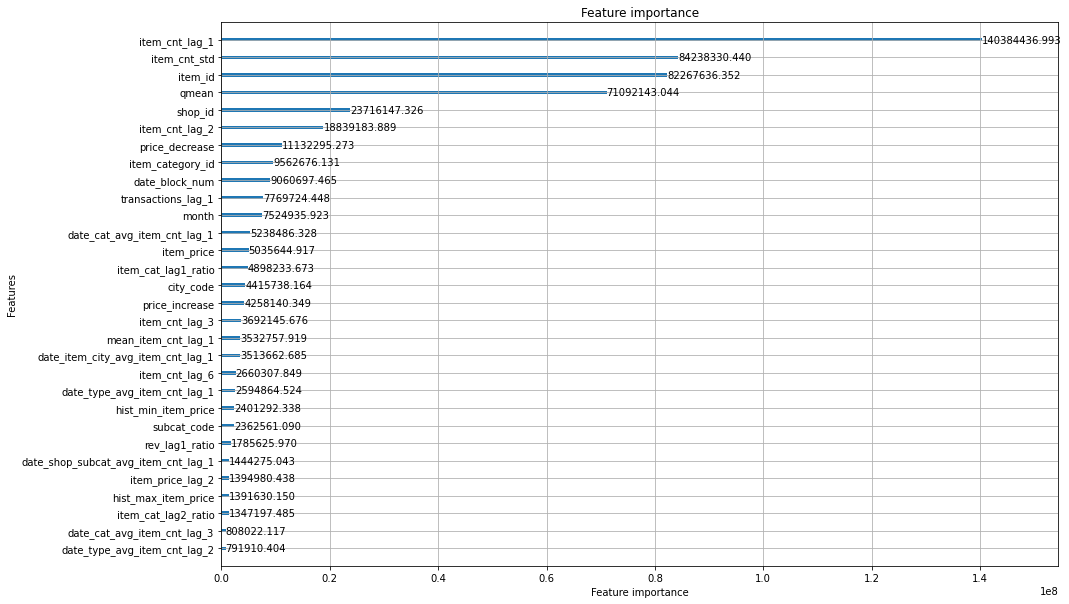

In [9]:
lgb.plot_importance(gbm, max_num_features=30, 
                    importance_type="gain", 
                    figsize=(15, 10))

# To be continued